using cupy edt
Chamfer Distance 0.0002637045690789819
SSIM 0.749552081070617
PSNR 12.917647563059571


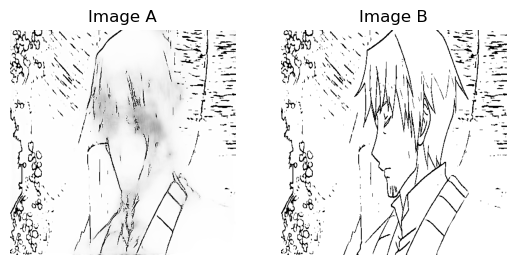

In [3]:
'''
Returns the Chamfer Distance between two images
'''
# import sys
# sys.path.append('../')
from _eval.chamfer_dist import batch_chamfer_distance
from skimage.metrics import structural_similarity as get_ssim
from skimage.metrics import peak_signal_noise_ratio as get_psnr
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from torchvision.transforms import CenterCrop


path_a = '/data/farriaga/Experiments/exp_padded/cool_test/triplet_34_0_pred.gif'
path_b = '/data/farriaga/Experiments/exp_padded/cool_test/triplet_34_0_true.gif'
gif = True

if gif:
    frame = Image.open(path_a)
    frame.seek(1)
    img_a = frame.convert('L').copy()
    frame = Image.open(path_b)
    frame.seek(1)
    img_b = frame.convert('L').copy()
else:
    img_a = Image.open(path_a).convert('L')
    img_b = Image.open(path_b).convert('L')



# Read batch of images as torch tensors
img_a = torch.tensor(np.array(img_a), dtype=torch.float32)
img_a = img_a / img_a.max()
img_b = torch.tensor(np.array(img_b), dtype=torch.float32)
img_b = img_b / img_b.max()
# create blank image: image with white pixels only (value of 1) with the same shape of image b
# img_a = torch.ones_like(img_b)- 1.0
copy_imga = img_a.clone()
copy_imga = CenterCrop((373, 373))(copy_imga)
save_image(copy_imga, 'img_a.png')

ssim = get_ssim(img_a.cpu().numpy(), img_b.cpu().numpy(), multichannel=False, data_range=1.0)
psnr = get_psnr(img_a.cpu().numpy(), img_b.cpu().numpy(), data_range=1.0)


# Unsqueeze to add batch dimension if there aren't any (batch_chamfer_distance() expects a batch of images)
if len(img_a.shape) < 3:
    img_a = img_a.unsqueeze(0)
    img_b = img_b.unsqueeze(0)


# Calculate Chamfer Distance
chamfer_distance = batch_chamfer_distance(img_a, img_b, bit_reverse=True)
print('Chamfer Distance', chamfer_distance.item())
print('SSIM', ssim)
print('PSNR', psnr)


# Visualize the images
plt.figure()
plt.subplot(1, 2, 1)  # arguments are nrows, ncols, index
plt.imshow(img_a.squeeze(0), cmap='gray')
plt.title("Image A")
plt.grid(False)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_b.squeeze(0), cmap='gray')
plt.title("Image B")
plt.grid(False)
plt.axis('off')

plt.show()

In [4]:
import torch
import pathlib
from PIL import Image
from torchvision import transforms
from _generators.generator_padded import UNetPadded



def generate(model, checkpoint_path, input_triplet_path, binary_thresh=0.0, crop_shape=None):
    transform=transforms.Compose([transforms.ToTensor(),
                            transforms.Grayscale(num_output_channels=1),
                            transforms.Resize((512, 512), antialias=True),])

    frame1 = transform(Image.open(pathlib.Path(input_triplet_path) / 'frame1.png'))
    frame3 = transform(Image.open(pathlib.Path(input_triplet_path) / 'frame2.png'))

    # Add batch dimension
    frame1 = frame1.unsqueeze(0)
    frame3 = frame3.unsqueeze(0)


    # Loads a model from a checkpoint
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()

    # Generates in-between frame for a given triplet
    in_between = model(frame1, frame3)

    # performs center crop if specified with torch center crop
    if crop_shape:
        in_between = transforms.CenterCrop(crop_shape)(in_between)

    if binary_thresh > 0.0:
        in_between[in_between >= binary_thresh] = 1.0
        in_between[in_between < binary_thresh] = 0.0

    return in_between


model = UNetPadded(2, output_channels=1, hidden_channels=64)
checkpoint_path = '/data/farriaga/Experiments/exp_paddedd/gen_checkpoint.pth'
input_triplet_path = '/home/farriaga/gan-interpolator/mini_datasets/mini_real_test_triplets/toradora_1'
in_between = generate(model, checkpoint_path, input_triplet_path, binary_thresh=0.0)

Using UNetPadded


In [5]:
from PIL import Image, ImageSequence
from torchvision import transforms
import numpy as np

def crop_gif(input_path, shape=(373,373)):
    gif = Image.open(input_path)

    frames = []
    # Define the CenterCrop transform
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=1),
        transforms.CenterCrop(shape)
    ])

    for frame in ImageSequence.Iterator(gif):
        # Center crop frame to size of shape with torch transforms
        cropped = transform(frame)
        cropped = cropped / cropped.max()
        cropped = (cropped > 0.5).float()
        cropped = transforms.ToPILImage()(cropped)
        frames.append(cropped)
    
    frames[0].save(input_path[:-4] + '_cropped.gif', save_all=True, append_images=frames[1:], 
                duration=500, loop=0)
    
    print('Cropped gif saved at', input_path[:-4] + '_cropped.gif')
        


In [6]:
# from _utils.utils import crop_gif
import os
crop_gif('/data/farriaga/Experiments/exp_padded/cool_test/triplet_34_0_pred.gif')

Cropped gif saved at /data/farriaga/Experiments/exp_padded/cool_test/triplet_34_0_pred_cropped.gif


In [7]:
from _utils.utils import mark_frame_in_gif
mark_frame_in_gif('/data/farriaga/Experiments/exp_padded/cool_test/triplet_34_0_pred_cropped.gif')

Saved marked GIF to /data/farriaga/Experiments/exp_padded/cool_test/triplet_34_0_pred_cropped_marked.gif


In [8]:
from _utils.utils import mark_frame_in_gif
import os

# read all gifs in a directory
path = 'mini_datasets/cd_visualizer_gifs'
for gif in os.listdir(path):
    # join path and gif name
    mark_frame_in_gif(os.path.join(path, gif), frame_index=1)

FileNotFoundError: [Errno 2] No such file or directory: 'mini_datasets/cd_visualizer_gifs'

In [ ]:
import sys
sys.path.append('../')

from torchsummary import summary

from _generators.generator_crop import UNetCrop
from _generators.generator_light import GeneratorLight
from _generators.generator_light_spectral import GeneratorLightSpectral
from _discriminators.discriminator_crop import DiscriminatorCrop
from _discriminators.discriminator_full import DiscriminatorFull
from _discriminators.discriminator_full_spectral import DiscriminatorFullSpectral
from _discriminators.discriminator_crop_double import DiscriminatorCropDouble

# Counts the number of parameters in a pre-trained network
model = DiscriminatorFull(1, 16).cuda()
summary(model, input_size=[(1, 512, 512)])